In [1]:
%load_ext autoreload
%autoreload 2

import qc_utils as utils
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import sympy
import itertools
import numpy as np

# Forward

# The portfolio rebalancing optimization problem

Suppose there are $N$ risky assets that have a mean return $\mu_k$ and a volatility $\sigma_k$. There is a vector ${\bf z} = [z_1, ..., z_n]$, where $z_k = \lbrace -1,0,1 \rbrace $ that represents our current holdings. A value of $+1 (-1)$ indicates that we currently hold (short) the $k$-th asset and a value of $0$ indicates that we do not take any position for that asset.

The optimal portfolio is the one that minimizes the return-risk cost function $C_{RR}({\bf z})$ given by

$$
C_{RR}({\bf z}) = -\sum_k (1-\lambda) r_k z_k + \lambda\sum_{kj} \sigma_{kj} z_k z_j,
$$


where $0 \leq \lambda \leq 1$ represents an asset manager control parameter that balances the return-risk trade-off, $\lambda=0$ favours returns and $\lambda = 1$ favours the risk.

## The trading costs

The change of the vector ${\bf z}$ incuurs trading fees. Those amount of fees that this change genertes will be given contained in the trading-cost function

$$
C_{TC}({\bf z}) = \sum_j (1-\delta(z_i-y_i))T,
$$


where the vector ${\bf y}$ represents the previous positions of the portfolio, $T$ is the transaction fee and $\delta$ is the discrete Kronecker delta function.

## Trading constraints

The above problem should be solved under the condition that we have a discrete number of assets to be invested

$$
\sum_j z_j =D 
$$

# Function encoding

The variable $z_j = \lbrace -1,0,1\rbrace$ is encoded as a difference of two spin variables 
as

$$
z_j = \frac{1}{2}\left( s^+_j-s^-_j \right),
$$
where 

$$
s^{\pm}_j = \lbrace -1,1 \rbrace.
$$


### Return-risk function

$$
\begin{align}
C_{RR}({\bf z}) &= -\sum_k (1-\lambda) r_k z_k + \lambda\sum_{kj} \sigma_{kj} z_k z_j, \\
 &= -\sum_k \frac{ (1-\lambda)}{2} r_k\left( s^+_k-s^-_k\right) + \frac{\lambda}{4}\sum_{kj} \sigma_{kj} \left( s^+_k-s^-_k\right) \left( s^+_j-s^-_j\right),
\end{align}
$$

### Soft constraint encoding

$$
\begin{align}
P_{\rm INV}(z) &= A\left(\sum_j z_j-D\right)^2\\
&= A\left(\sum_{jk} z_k z_j-2D\sum_j z_j+D^2 \right)\\
&= \sum_{kj} \frac{A}{4} \left( s^+_k s^+_j-s^+_k s^-_j - s^-_k s^+_j+ s^-_k s^-_j \right) -AD\sum_{j} (s^+_j-s^-_j)+AD^2
\end{align}
$$


The simple method of choosing the the penalty scaling coefficient $A$ is to choose 

$$
A > \text{max}\lbrace C_{RR}({\bf s})+C_{TC}({\bf s}) \rbrace-\text{min}\lbrace C_{RR}({\bf s})+C_{TC}({\bf s}) \rbrace
$$

### Transaction cost encoding

To encode the transcation cost, we factorize the discrete Dirac-delta function as

$$
\delta(z-y) = c_0(z-y-2)(z-y-1)(z-y+1)(z-y+2),
$$

where $z,y \in \lbrace -1,0,1 \rbrace$ noting that $\delta(z-y) =0$ except when $z=y$, where $\delta(z-y) =1$. This implies that

$$
\begin{align}
\delta(z-y) &= \frac{1}{4}(z-y-2)(z-y-1)(z-y+1)(z-y+2),\\
&= \left(\frac{3}{2}y^2-1 \right)z^2+(1-y^2)+\frac{1}{2}yz.
\end{align}
$$

and so,

$$
\begin{align}
C_{TS}(s_i) &= T(1 - \delta(s_i-y_i) ),\\
&= T \left(1-\left(\frac{3}{2}y^2-1 \right)z^2-(1-y^2)-\frac{1}{2}yz \right),\\
&= T \left(-\frac{1}{2}\left(\frac{3}{2}y^2-1 \right)(1-s^+_is^-_i)-y^2-\frac{1}{4}y(s^+_i- s^-_i). \right)
\end{align}
$$

This last function generates all of the correct combinations except for $(y_i,s_i^+,s_i^-)=(0,1,1)$. There we would like this function to generate the value $T$ instead of $0$. To carry this out, we will add a function $g(s_i)$ that is zero for $y^2_i=1$ and for  $y_i,s_i^+,s_i^- = (0,-1,-1),(0,-1,1),(0,-1,1)$. Furthermore,$g(s^+_i,s^-_i)=T$. This function is easily found to be

$$
g(s_i) = \frac{T}{4}\left(1+s^+_i s^-_i +s^-_i +s^+_i \right)(1-y^2_i).
$$


Adding this additional peanlization term, we arrive at the cost-function encoding 

$$
\begin{align}
C_{TS}(s_i) = \frac{1}{4}T\left( 3+(1-y^2_i-y_i)s^{+}_{i}+(1-y^2_i+y_i)s^{-}_{i}+(2y^2_i-1)s^{+}_{i}s^{-}_{i} \right)
\end{align}
$$


In [2]:
# Here we verify that this cost function reproduces all values in the paper 
# by M. Hodson 2019


def C_stored(sm,sp,y):
    '''
    The Tabulated values, (T=1)
    for Table II of Hodson et. al. 2019
    '''
    
    sm = int((sm+1)/2)
    sp = int((sp+1)/2)
    y = y+1
    
    A = np.zeros((3,2,2))
    A[0,0,0]=1
    A[0,0,1]=1
    A[0,1,0]=0
    A[0,1,1]=1
    
    A[1,0,0]=0
    A[1,0,1]=1
    A[1,1,0]=1
    A[1,1,1]=1
    
    A[2,0,0]=1
    A[2,0,1]=0
    A[2,1,0]=1
    A[2,1,1]=1
    
    return A[y,sm,sp]

def C_TC(sm,sp,y):
    '''
    C_{TC}(s,y) function
    
    sm -> s^-_k
    sp -> s^+_k
    
    where:
    sm: {-1,1}
    sp: {-1,1}
    '''
    return 1/4*(3+(1-y**2-y)*sp+(1-y**2+y)*sm+(2*y**2-1)*sp*sm)

# Enumerate all possible input combinations
y_index = [-1,0,1]
sp_index = [-1,1]
sm_index = [-1,1]
combinations = itertools.product(y_index,sp_index,sm_index)

for y,sp,sm in list(combinations):
    print('Function input values: y={}, s^+_k={}, s^-_k={}'.format(y,sp,sm))
    print('Cost function value: {}'.format(C_TC(sm,sp,y))) 
    print('Stored value: {}'.format(C_stored(sm,sp,y)))
    print('')

Function input values: y=-1, s^+_k=-1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=-1, s^+_k=-1, s^-_k=1
Cost function value: 0.0
Stored value: 0.0

Function input values: y=-1, s^+_k=1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=-1, s^+_k=1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=-1, s^-_k=-1
Cost function value: 0.0
Stored value: 0.0

Function input values: y=0, s^+_k=-1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=-1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=-1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=1, s^-_k=-1
Cost function value: 0.0
Stored value: 0.0

Funct

In [3]:
%load_ext autoreload
%autoreload 2

import qc_utils as utils
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import sympy
import itertools
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


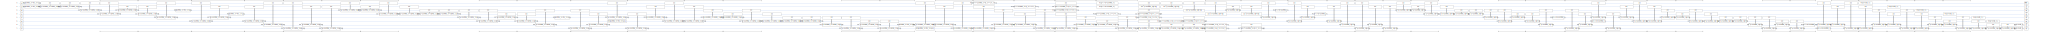

In [4]:
# Define the number of portfolios to optimize
N_portfolio = 4

# Instantiate the portfolio 
portfolio1 = utils.Portfolio(N_portfolio=N_portfolio)

# Generate a QAOA circuit with p=1 depth
QAOA_circuit = portfolio1.QAOA_circuit(p=1)

# plot the circuit
SVGCircuit(QAOA_circuit)

In [20]:
# Get the benchmark parameters
benchmark_parameters = portfolio1.benchmark_values()

In [21]:
best_bruteforce_result = portfolio1.brute_force_search(benchmark_parameters)

In [34]:
QAOA_results = portfolio1.grid_search(QAOA_circuit,N_grid=20,parameters=benchmark_parameters,n_trials=100)

penalty_cost_grid = QAOA_results['penalty_cost_grid']
best_holdings = QAOA_results['min_portfolio_holdings']

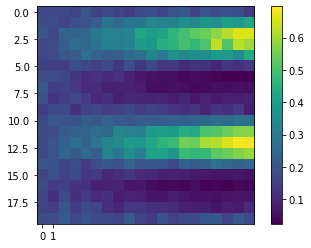

In [35]:
plt.imshow(penalty_cost_grid)
plt.xticks([0,1])
plt.colorbar()
plt.show()

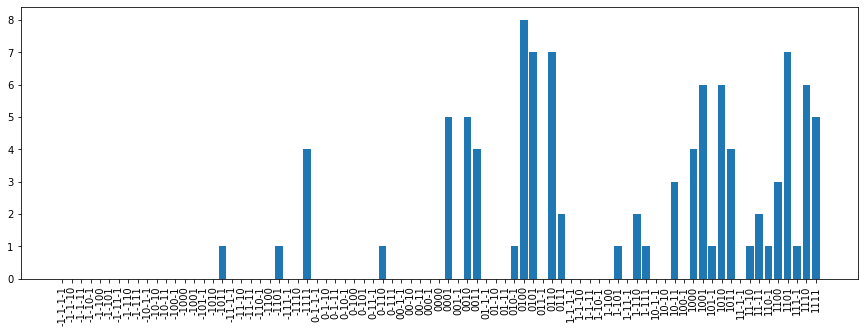

In [36]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(len(QAOA_results['min_portfolio_holdings']['labels'])), QAOA_results['min_portfolio_holdings']['counts'], tick_label=QAOA_results['min_portfolio_holdings']['labels'])
plt.xticks(rotation=90)
plt.show()

In [37]:
best_QAOA_result = portfolio1.determine_best_solution_from_trials(benchmark_parameters,best_holdings)

In [57]:
# Generate a QAOA circuit with p=1 depth
QAOA_circuit_p = portfolio1.QAOA_circuit(p=2)

# Optimize the circuit using Scipy-optimizer
optimization_results = portfolio1.optimize_circuit(circuit=QAOA_circuit_p,parameters=benchmark_parameters,n_trials=100,p=2)

In [58]:
print(best_QAOA_result['minimum_cost_states'])
print(best_bruteforce_result['minimum_cost_states'])
print(optimization_results['best_solutions']['minimum_cost_states'])

[[1 0 1 0]]
[[1 0 1 0]]
[[1 0 1 0]]


In [125]:
# Generate a QAOA circuit with p=1 depth
QAOA_circuit_p = portfolio1.QAOA_circuit(p=1)

xx,sig_xx =portfolio1.optimize_circuit_angles_cross_entropy(QAOA_circuit_p,
                                                              benchmark_parameters,
                                                              p=1,
                                                              n_trials=20,
                                                              iterations=10,
                                                              f_elite=0.2,
                                                              Nce_samples = 50)

print(sorted_data)

0 0.08908273284999998 0.02091851851549257
1 0.08728025345 0.014426434639254455
2 0.08759063204999999 0.02451908794869265
3 0.07066546445 0.01398846835474705
4 0.0558050539 0.00885188547414188
5 0.04276413685 0.01298154189696605
6 0.033196941349999995 0.005528063393737784
7 0.0304626084 0.0050069816485932474
8 0.030753556349999996 0.0021122262755266085
9 0.025062641749999996 0.004613461392331182
[4.70429384 2.16023916]


In [127]:
print(best_bruteforce_result['minimum_cost'])
print(optimization_results['optimal_energy_measurement'])

0.00018825000000000008
0.1953008611
